<a href="https://colab.research.google.com/github/hallmx/DL_medical_imaging_cle-ai/blob/master/siim_pneumothorax_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*This notebook is designed to be run as a Kaggle kernal*

# SIIM Pneumothorax Segmentation

Using deep learning to identify and segment pneuomothorax disease on chest X-rays.

### **Background**

Pneumothorax is a medical problem which occurs when air escapes through a hole in the lung and becomes trapped between the outer lining of the lung (pleura) and the chest wall. As more air accumulates, the lung is compressed and may ultimately collapse on the affected side. Clinical symptoms of pneumothorax are mainly shortness of breath (dyspnea) and chest pain when breathing (pleurisy). Rarely, sufficient air accumulates to put pressure on all the contents of the thoracic cavity, heart and graet vessels included, which can be fatal if untreated.

Diagnosis is made by clinical examination (reduced chest sounds and hyper-resonance of the chest over the side of the pneumothorax) and confirmatory chest X-ray where pneumothoraces most often show up as a visible plural edge and rim of reduced lung marking around the inside of the chest wall. The collapsed lung itself may be hypolucent.

Treatment is usually by inserting a tube through the chest wall into the pleural space to release the trapped air allowing the lung to reinflate, though some smaller less symptomatic pneumothoraces can be managed by aspiration or managed conservatively (no treatment).


### **Purpose**

To develop a DNN model for identifying and segmenting pneumothorax on chest X-ray. Such a model may find clinical use within radiology and emergency room workflows as an adjunct to physician inspection of X-rays for pneumothorax. 

### **Data**

Data was obtained from Kaggle https://www.kaggle.com/jesperdramsch/siim-acr-pneumothorax-segmentation-data. 

* dicom-images-train (contains the training X-rays in dicom format 
* train-rle-csv (contains the labels for he training images)
* dicom-images-test (the test images for competition submission)

dicom-images-train contains 10712 chest X-rays, 8,333 of which have no pneumothorax (either normal or other chest diseases) and 2379 have a pneumothorax. train-rle-csv contains a csv file with image IDs linked to the SopInstanceIUID of the associated DICOM file and the associated labels, either ' -1' for no pneumothorax or a run length encoded (RLE)segmentation mask. RLE is a compressed image format used where there are only a small number of colors in the image. Thirty seven X-rays are unlabelled and we deal with those in the notebook. 

### **Methodology**

Data is downloaded and examined for missing labels, pneumothorax sizes and multiple pnuemothoraces. Images in the form of dicom pixel arrays are converted to png files and saved to disk. Labelling takes the png file name, identifies the corresponding imageID in train-rle-csv and converts the run length encoded mask (RLE) into a mask image. Png images and corresponding masks are then combined in a dataloader. 

We use the fastai2 deep learning library to train a resnet34 CNN and U-net architecture. U-nets perform well and are widely used in medical image segmentation tasks. The datset is relatively small we use progressive resizing of images from 96x96px, 144x144px and 256x256px to regularise during training. After 5 epochs training at each image size we unfreeze the model and train for a further 5 epochs. Training was evaluated using the DICE metric which calculates intersection over union of label (segmentation masks) and segmented predictions.

Fastai2 code for segmentation analysis based on https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/04_Segmentation.ipynb and https://www.kaggle.com/jhoward/fastai-v2-pipeline-tutorial

### **Results**

Here we successfully develop a DNN model able to identify and segment pneumothorax on chest X-ray. The model gave an overall DICE of 0.79 on the validation set which compares favourably with other competition entries. Comparison of labels (segmentation masks) and predictions on samples from the validation set shows successful identification and localization of pneumothoraces in many cases. Manual inspection of X-rays and predictions on samples from the unlabelled test set also shows successful identification of pneumothoraces, though with a higher degree of background pixel noise.  

### **Next steps**

* Train using larger image sizes. Original DICOM pixel arrays were 1024x1024px and we used a maximaum image size of 256x256px due to GPU memory limitations. Continuing to increase the image size to 512 or 1024px would likely give better results. 
* Experiment with other architectures. Resnet 50 or a densenet might be good choices to try. 
* We use basic data-augmentation techniques (automatically applied to input image and mask by fastai) but we could experiment with augmentation parameters and try additional techniques. 
* The dataset is unbalanced with only a quarter as many X-rays with pneumothoraces compared to those without. Upsampling the under-represented set by generating augmented images or by generated synthetic data may improve training performance. 


## Notebook Setup

In [0]:
pip install fastai2            

In [0]:
pip install pydicom kornia opencv-python scikit-image

## Import libraries

In [0]:
# General
import os, glob2
from pathlib import Path
from joblib import Parallel, delayed
from tqdm import tqdm_notebook as tqdm


# Data manipulation
import pandas as pd
import numpy as np
from random import sample, shuffle, randint
from sklearn import metrics, model_selection
from math import ceil

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Image manipulation
import PIL, cv2
from skimage.io import imread, imshow
import pydicom

# Visualizations
import matplotlib as plt
import matplotlib.patches as patches
import seaborn as sns

# Matplotlib options
plt.rcParams['font.size']=12

# DL libraries
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from fastai2.data.all import *
from fastai2.vision.core import *
from fastai2.vision.data import *
from fastai2.medical.imaging import *
from torch import torch

In [0]:
import warnings 
warnings.filterwarnings("ignore")

In [0]:
print("GPU: ", torch.cuda.is_available())
print("python PIL version - ", PIL.PILLOW_VERSION)

GPU:  True
python PIL version -  5.4.1


## Parameters and paths

In [0]:
# data directory
DATA_PATH = Path('/kaggle/input/siim-acr-pneumothorax-segmentation-data/pneumothorax')
!ls {DATA_PATH}

dicom-images-test  dicom-images-train  train-rle.csv


In [0]:
# data paths
TRAIN_PATH = DATA_PATH/'dicom-images-train'
KAGGLE_TEST_PATH = DATA_PATH/'dicom-images-test'
print(TRAIN_PATH) 

# Directory to save logs and trained model
ROOT_DIR = '/kaggle/working'

/kaggle/input/siim-acr-pneumothorax-segmentation-data/pneumothorax/dicom-images-train


## Get data

In [0]:
dcm_items = get_files(TRAIN_PATH, extensions=[".dcm"], recurse=True, folders=None)
dcm_items[:1]

(#1) [Path('/kaggle/input/siim-acr-pneumothorax-segmentation-data/pneumothorax/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.11208.1517875231.726428/1.2.276.0.7230010.3.1.3.8323329.11208.1517875231.726427/1.2.276.0.7230010.3.1.4.8323329.11208.1517875231.726429.dcm')]

In [0]:
# view csv file containing image file id and rle encoded mask 

df_masks = pd.read_csv(str(DATA_PATH) + '/train-rle.csv', delimiter=",")
df_masks.rename(columns={' EncodedPixels': 'EncodedPixels'}, inplace=True)

print("train_rle.csv: -1 means no Pneumothorax, otherwise there is an rle encoding for the pneumothorax mask")
df_masks.head()

train_rle.csv: -1 means no Pneumothorax, otherwise there is an rle encoding for the pneumothorax mask


ImageId  \
0   1.2.276.0.7230010.3.1.4.8323329.5597.1517875188.959090   
1  1.2.276.0.7230010.3.1.4.8323329.12515.1517875239.501137   
2   1.2.276.0.7230010.3.1.4.8323329.4904.1517875185.355709   
3  1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312   
4  1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             EncodedPixels  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       -1  
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       -1  
2   175349 7 1013 12 1009 17 1005 19 1003 20 1002 22 1001 22 1000 23 1000 23 1000 23 999 24 999 23 1000 23 999 23 1000 22 1001 21 1001 22 1001 21 1002 21 1001 22 1001 21 1002 21 1001 22 1001 21 1002 21 1001 22 1001 21 1002 21 1002 21 1002 20 1003 20 1002 21 1001 23 1000 23 999 24 999 24 999 23 999 24 999 24 998 26 996 27 995 28 995 28 994 30 993 30 993 30 993 30 993 31 992 31 992 31 992 31 992 32 990 33 990 33 990 33 991 31 992 31 992 31 992 31 992 31 992 31 992 31 992 31 992 31 992 31 992 31 993 30 993 30 993 30 993 30 994 29 994 29 994 30 993 30 994 29 994 30 993 30 993 31 993 31 992 31 992...  
3   407576 2 1021 7 1015 10 1013 12 1011 14 1008 17 1006 19 1005 20 1003 21 1003 22 1001 23 1001 24 999 25 999 25 999 26 997 27 997 27 996 28 996 28 996 29 994 30 994 30 994 30 993 31 993 32 992 32 992 32 992 32 991 33 991 33 991 33 991 33 991 33 990 34 990 34 990 34 990 34 990 34 989 35 989 36 988 36 988 16 1 19 988 15 3 18 988 15 4 16 989 14 8 13 989 14 8 13 989 13 9 13 989 13 9 13 989 12 10 13 989 12 10 13 989 11 11 13 989 11 11 13 989 11 11 13 989 10 11 14 989 10 11 14 990 9 9 16 990 9 7 18 990 9 6 18 991 9 6 18 991 9 5 19 992 8 4 20 992 7 5 20 993 6 4 21 993 6 4 21 994 4 4 22 995 3 5 20 ...  
4   252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1015 8 1014 9 1014 9 1013 10 1013 10 1012 11 1011 12 1010 12 1011 12 1010 13 1009 14 1008 15 1008 15 1007 16 1007 16 1006 17 1006 17 1005 17 1005 18 1004 19 1004 18 1004 19 1004 19 1002 21 1001 22 1001 22 1000 23 1000 23 999 24 997 26 997 25 997 26 997 26 997 26 996 27 996 27 996 27 995 27 996 27 996 27 996 28 995 28 995 28 995 28 994 28 995 28 995 28 995 27 996 27 996 27 996 28 995 28 995 28 995 28 994 30 993 30 993 30 994 29 994 28 995 28 995 28 994 30 993 30 993 30 994 29 994 30 993 30 993 30 994 30 993 30 993 30 993 31 992 31 992 32 991 32 9...

## Utils

In [0]:
# mask functions provided by kaggle from sample dataset

def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    mask = mask.reshape(width, height)
    mask = np.rot90(mask, 3)
    mask = np.flip(mask, axis=1)
    return mask


In [0]:
def display_dcm_img(f):
    "Display an DICOM image from filename `f`"
    img = pydicom.read_file(str(f)).pixel_array
    plt.imshow(img, cmap='bone')
    plt.grid(False)

In [0]:
# garbage collect
import gc
def clean_up(vars):
    for v in vars:
        del v
    gc.collect()

## EDA

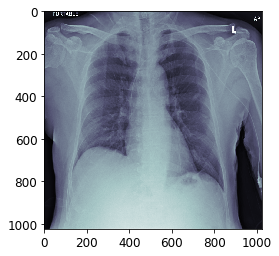

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.11208.1517875231.726429
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: AP'
(0010, 0010) Patient's Name                      PN: '0523f3e4-2570-40e5-93e5-4e07ec515b14'
(0010, 0020) Patient ID                          LO: '0523f3e4-2570-40e5-93e5-4e07ec515b14'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient'

In [0]:
# display an image with associated DICOM data
display_dcm_img(dcm_items[0]); plt.show()

#displaying metadata
dcm_items[0].dcmread()

In [0]:
# create dataframe with DICOM metadata and paths to corresponding images
# at the same time check for missing labels
patients = []
missing_labels = 0

for p in dcm_items:
    data = pydicom.dcmread(str(p))
    patient = {}
    patient['UID'] = data.SOPInstanceUID
    try:
        encoded_pixels = df_masks[df_masks.ImageId == data.SOPInstanceUID]['EncodedPixels']
        patient['encoded_pixels'] = encoded_pixels.values[0]
    except:
        missing_labels += 1
    finally:
        patient["Age"] = data.PatientAge
        patient["Sex"] = data.PatientSex
        patient["Modality"] = data.Modality
        patient["BodyPartExamined"] = data.BodyPartExamined
        patient["ViewPosition"] = data.ViewPosition
        patient["PixelSpacing"] = [round(x, 3) for x in data.PixelSpacing]
        patient["path"] = Path(TRAIN_PATH / data.StudyInstanceUID / data.SeriesInstanceUID / Path(str(data.SOPInstanceUID) + '.dcm'))
    patients.append(patient)

print(f'Num missing labels: {missing_labels} / {len(patients)}')

cols = patients[0].keys()
df_train = pd.DataFrame(patients, columns=cols)

pd.reset_option('max_colwidth')
df_train.head()

Num missing labels: 37 / 10712


UID  \
0  1.2.276.0.7230010.3.1.4.8323329.11208.15178752...   
1  1.2.276.0.7230010.3.1.4.8323329.1189.151787516...   
2  1.2.276.0.7230010.3.1.4.8323329.5490.151787518...   
3  1.2.276.0.7230010.3.1.4.8323329.1492.151787516...   
4  1.2.276.0.7230010.3.1.4.8323329.2270.151787517...   

                                      encoded_pixels Age Sex Modality  \
0                                                 -1  62   M       CR   
1                                                 -1  33   F       CR   
2                                                 -1  33   M       CR   
3   533580 1 1019 6 1015 10 1011 14 1009 15 1007 ...  47   M       CR   
4                                                 -1  21   F       CR   

  BodyPartExamined ViewPosition    PixelSpacing  \
0            CHEST           AP  [0.139, 0.139]   
1            CHEST           AP  [0.168, 0.168]   
2            CHEST           AP  [0.168, 0.168]   
3            CHEST           AP  [0.139, 0.139]   
4            CHEST           PA  [0.143, 0.143]   

                                                path  
0  /kaggle/input/siim-acr-pneumothorax-segmentati...  
1  /kaggle/input/siim-acr-pneumothorax-segmentati...  
2  /kaggle/input/siim-acr-pneumothorax-segmentati...  
3  /kaggle/input/siim-acr-pneumothorax-segmentati...  
4  /kaggle/input/siim-acr-pneumothorax-segmentati...

In [0]:
no_ptx = df_train[df_train['encoded_pixels'] == ' -1'].shape[0]
print(f'Total sampes: {len(df_train)}\nWithout pneumothorax: {no_ptx}\nWith pneumothorax: {len(df_train)-no_ptx}')

Total sampes: 10712
Without pneumothorax: 8296
With pneumothorax: 2416


### Deal with missing labels

Sample of images with missing labels (6 out of 37)


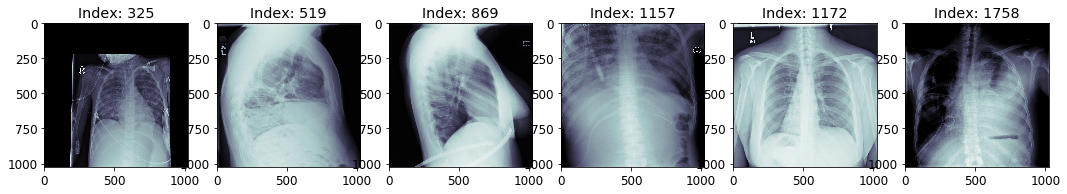

In [0]:
# lets collect the imags with missing labels together and print a selection
df_no_label = df_train[df_train['encoded_pixels'].isnull()]

print(f'Sample of images with missing labels (6 out of {len(df_no_label)})')
fig, axes = plt.subplots(1, 6, figsize=(18, 6))
for i, idx in enumerate(list(df_no_label.index.values)[:6]):
    plt.subplot(1, 6, i+1)
    display_dcm_img(df_no_label.at[idx, 'path'])
    plt.title(f'Index: {idx}')
plt.show()
clean_up(df_no_label); pass

Radiological examination of all images with missing labels reveals that none have visible pneumothorax. Thus we shall label them all -1.

In [0]:
# replace missing labels (NaNs) with ' -1' as leaving NaNs will throw an error during training.
df_train.fillna(' -1', inplace=True)

### Create new dataframe of samples with pneumothorax

In [0]:
# create a new dataframe of samples positive for pneumothorax
df_ptx = df_train[df_train.encoded_pixels  != ' -1'].copy()
df_ptx.head()

UID  \
3   1.2.276.0.7230010.3.1.4.8323329.1492.151787516...   
7   1.2.276.0.7230010.3.1.4.8323329.14599.15178752...   
11  1.2.276.0.7230010.3.1.4.8323329.1885.151787517...   
16  1.2.276.0.7230010.3.1.4.8323329.11159.15178752...   
20  1.2.276.0.7230010.3.1.4.8323329.5558.151787518...   

                                       encoded_pixels Age Sex Modality  \
3    533580 1 1019 6 1015 10 1011 14 1009 15 1007 ...  47   M       CR   
7    642137 1 1023 3 1020 5 1019 5 1018 6 1018 6 1...  66   F       CR   
11   306421 4 1019 6 1017 7 1016 8 1015 9 1014 10 ...  71   M       CR   
16   250202 7 1012 14 1006 20 1003 22 1000 24 999 ...  39   F       CR   
20   181590 4 1018 7 1015 9 1014 9 1013 10 1013 11...  37   M       CR   

   BodyPartExamined ViewPosition    PixelSpacing  \
3             CHEST           AP  [0.139, 0.139]   
7             CHEST           PA  [0.194, 0.194]   
11            CHEST           PA  [0.143, 0.143]   
16            CHEST           PA  [0.168, 0.168]   
20            CHEST           PA  [0.143, 0.143]   

                                                 path  
3   /kaggle/input/siim-acr-pneumothorax-segmentati...  
7   /kaggle/input/siim-acr-pneumothorax-segmentati...  
11  /kaggle/input/siim-acr-pneumothorax-segmentati...  
16  /kaggle/input/siim-acr-pneumothorax-segmentati...  
20  /kaggle/input/siim-acr-pneumothorax-segmentati...

### View example images and masks 

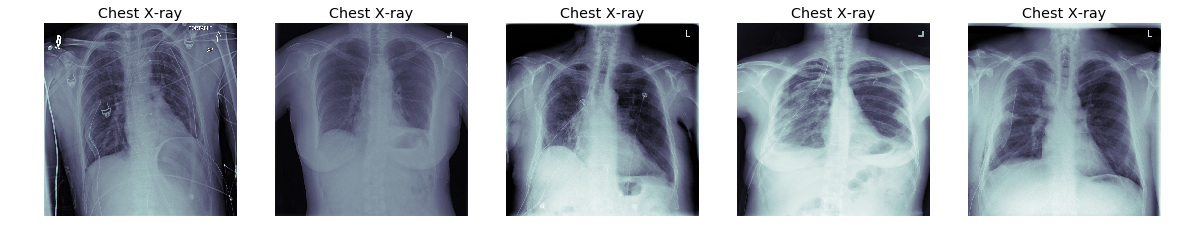

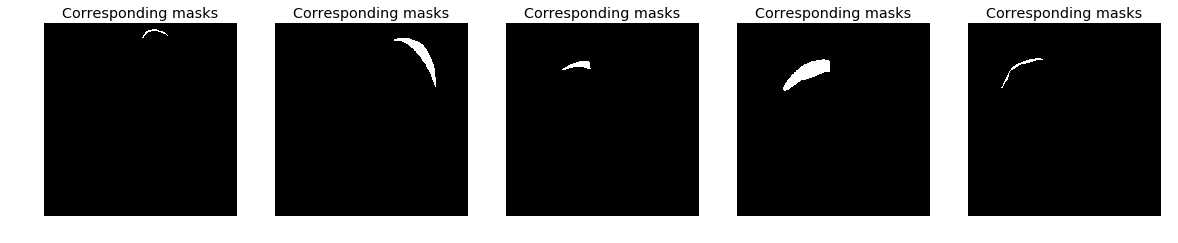

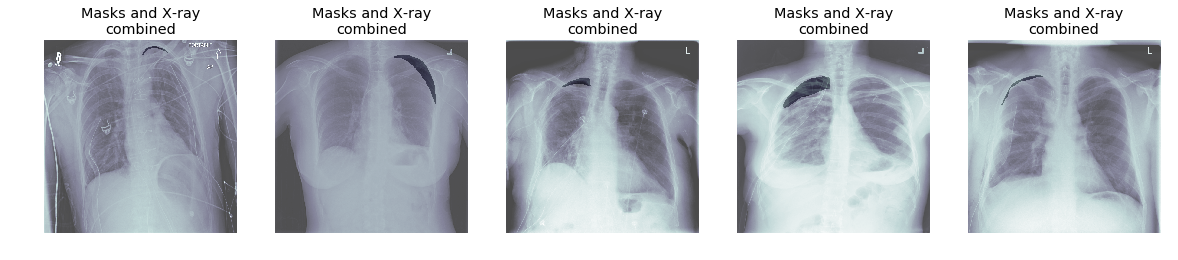

In [0]:
def show_imgs(df, title, mode='xray'):
  "Display selection of X-rays with pneumothorax, complimentray masks and X-ray with mask overlaid"

  cols = len(df)
  fig, axes = plt.subplots(1, cols, figsize=(cols*4,4))
  for i, row in enumerate(df.itertuples()):
    plt.subplot(1, cols, i+1)
    xray = pydicom.read_file(str(row.path)).pixel_array
    mask = rle2mask(row.encoded_pixels, 1024, 1024)
    if mode == 'xray': 
        plt.imshow(xray,cmap='bone')
    elif mode == 'mask': 
        plt.imshow(mask,cmap='bone')
    else:
        plt.imshow(xray, cmap='bone')
        plt.imshow(mask, cmap='binary', alpha=0.3)
    plt.axis('off')
    plt.title(title)
  plt.show()
    
show_imgs(df_ptx.head(), "Chest X-ray", mode='xray')
show_imgs(df_ptx.head(), "Corresponding masks", mode='mask')
show_imgs(df_ptx.head(), "Masks and X-ray\ncombined", mode='sup')

### View distribution of pneumothorax sizes

In [0]:
# get pnuemothorax sizes

def ptx_areas():
    "Calculate total area in pixels and mm of pneumothoraces."
    
    cols=['area','area_ap','area_pa','area_mm']
    for col in cols:
        df_ptx[col]=0
        
    for row in df_ptx.itertuples():
        idx = row.Index
        mask = rle2mask(row.encoded_pixels, 1024, 1024)
        mask_px = np.count_nonzero(mask)
        df_ptx.at[idx, ['area', 'area_mm']] = mask_px, round((mask_px*row.PixelSpacing[0]*row.PixelSpacing[1]), 2)
        if row.ViewPosition == 'AP':
            df_ptx.at[idx, 'area_ap'] = mask_px
        else:
            df_ptx.at[idx, 'area_pa'] = mask_px
                
ptx_areas()
# df_ptx.head()

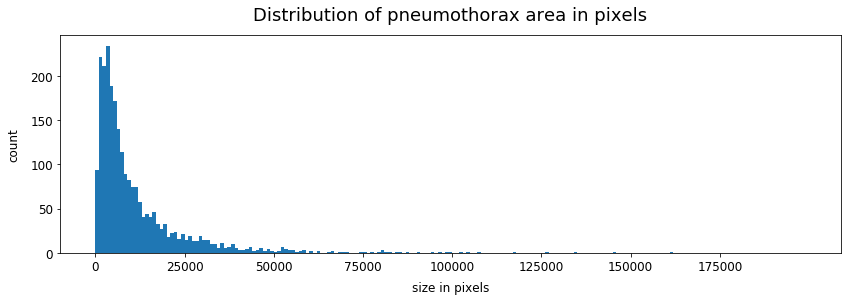

In [0]:
# plot pneumothorax sizes
plt.figure(figsize=(14, 4))
plt.hist(df_ptx['area'], bins=[i*1000 for i in range(0, 200)])
plt.title("Distribution of pneumothorax area in pixels", fontsize=18, pad=15)
plt.xlabel("size in pixels", labelpad=8)
plt.xticks([i*25000 for i in range(8)])
plt.ylabel("count", labelpad=10)
plt.show()

### Pneumothorax location

In [0]:
# stack all masks with pneumothoraces on top of each other 
mask_sum = np.zeros([1024,1024])

for row in df_ptx.itertuples():
    mask = rle2mask(row.encoded_pixels, 1024, 1024)
    mask_sum = mask_sum + mask
clean_up([mask, mask_sum]); pass

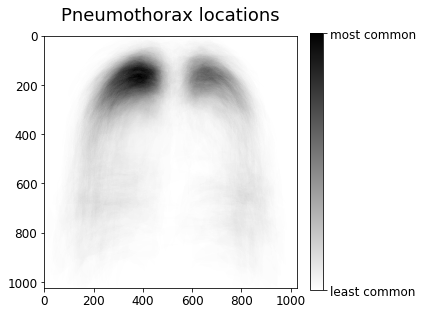

In [0]:
# Plot as a single image with colorbar
fig = plt.figure(figsize=(17, 5))
basic_palette = sns.color_palette()
ax1 = plt.subplot2grid((1, 3), (0, 0))
ax1.imshow(mask_sum, cmap='binary')
ax1.set_title("Pneumothorax locations", fontsize=18, pad=15)

#colorbar
maxval = np.max(mask_sum)
cmap = plt.get_cmap('binary', maxval)

norm = matplotlib.colors.Normalize()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

ticks=[1/(maxval+1)/2, 0.5, 1-1/(maxval+1)/2]

cb = plt.colorbar(sm,ticks=[0, 1], fraction=0.046, ax=ax1) #ticks and boundaries
cb.ax.set_yticklabels(["least common", "most common "]) #label of colormap
cb.ax.yaxis.set_label_position('left')

plt.grid(False)
plt.show()
clean_up([fig, sm, cb]); pass

Most pneumothoraces are relatively small and occur at the apices of the lungs. Clinically, the lung apices are certaily the most common position to find pneumothoraces, most are not small. The discrepancy between the dataset and clinical observation most likely arises due to a large number of pneumothoraces having already been treated with chest drainage (you can see the drainage tubes on the X-rays) when the Xray was taken and treatment (as you would expect) substantially reduces pneumothorax size. 

### Investigate multiple pneumothoraces

Pneumothoraces can be bilateral, or have more than one pocket of air in a single lung, so we would expect more than one contiguous RLE in soe of the labels 

In [0]:
# We can identify multiple RELs in the label RLE by looking for non-contigous runs. 
# Non-contigous runs are identified where there is a distance of greater than 1024 (the width of one row) between pixel runs
from collections import Counter

num_ptx = []
idxs = []

for idx, pxs in zip(df_ptx.index.values, df_ptx.encoded_pixels.values):
    lengths = [int(x) for x in pxs.split(" ")[1:] if int(x) > 1025]
    num_ptx.append(len(lengths))
    if len(lengths) > 6 : idxs.append((idx, len(lengths)))        
cnts = Counter(num_ptx)

df = pd.DataFrame([["masks:"]+[x[1] for x in sorted(cnts.items())]], columns = ['number non-contigous RLEs:','0','1','2','3','4','5','6','7','8','9','10','11']) 
print(f'\n{df.to_string(index=False)}\n')
clean_up([cnts, df]); pass


number non-contigous RLEs:  0     1   2   3   4  5  6  7  8  9  10  11
                    masks:  1  2263  64  21  11  7  3  3  2  2   1   1



The vast majority of labels (2263) contain a single contingous RLE representing a single pneumothorax as expected. However, a small number have two non-contiguous RLEs representing bilateral pneumothorax (usually arising from trauma). However, it is clinically unlikely any patient has several coexisting pneumothoraces, so let's plot those masks with more than 6 non-contigous RLEs to see what is going on

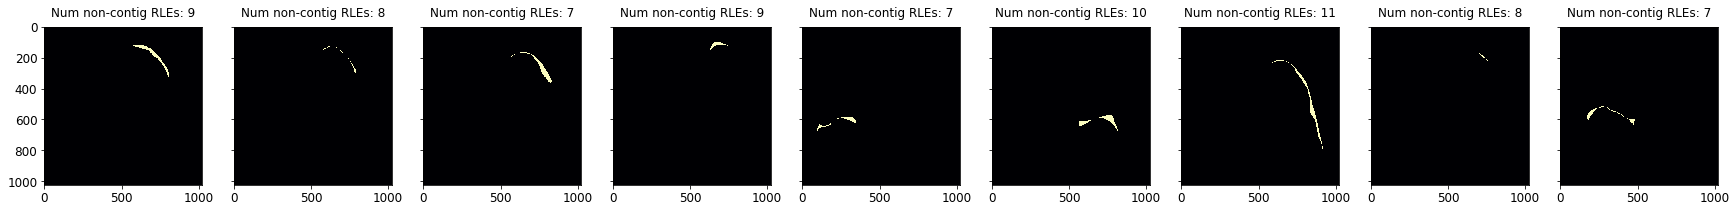

In [0]:
# Plot masks with > 6 non-contigous RLEs (stored in `idxs` above)

fig, ax = plt.subplots(nrows=1, ncols=9, sharey=True, figsize=(30,6))
for i, tup in enumerate(idxs):
    idx, num_rle = tup
    mask = rle2mask(df_ptx.at[idx, 'encoded_pixels'], 1024, 1024)
    ax[i].imshow(mask, cmap='magma')
    ax[i].set_title(f'Num non-contig RLEs: {num_rle}', fontsize=12, pad=10)

So it looks like the high number of non-contigous RLEs in some labels is an artifact of the labelling and in fact they are all part of a single clinical pneumothorax. Thus, we can ignore this.

## DICOM to png

DICOM pixel arrays must be converted to png images for use with unet Learner. We could convert files as needed but this woul dslow training considerably so a more efficient way is to create a new folder of png files labelled with the SOPINstanceUID as filenames. We have 8 CPU cores available to us on kaggle - so lets use them! Code adapted from https://www.kaggle.com/abhishek/convert-to-png-on-steroids-with-actual-data

In [0]:
def convert_images(filename, outdir):
    ds = pydicom.read_file(str(filename))
    img = ds.pixel_array
    img = cv2.resize(img, (256, 256))
    cv2.imwrite(outdir + filename.split('/')[-1][:-4] + '.png', img)
    
train_png_path = 'train_png/'
train_dcm_list = glob2.glob(os.path.join(TRAIN_PATH, '**/*.dcm'))
    
if not os.path.exists(train_png_path):
    os.makedirs(train_png_path)
    
res = Parallel(n_jobs=8, backend='threading')(delayed(convert_images)(i, train_png_path) for i in tqdm(train_dcm_list, total=len(train_dcm_list)))
clean_up([res, dcm_items, train_dcm_list]); pass

In [0]:
# get paths to png files 
trn_items = get_files(train_png_path, extensions=[".png"], recurse=True, folders=None)

print(f'Num items train set: {len(trn_items)}\n')
for p in trn_items[:5]:
    print(p)

Num items train set: 10712

train_png/1.2.276.0.7230010.3.1.4.8323329.10472.1517875223.864249.png
train_png/1.2.276.0.7230010.3.1.4.8323329.11676.1517875234.255808.png
train_png/1.2.276.0.7230010.3.1.4.8323329.13179.1517875244.24231.png
train_png/1.2.276.0.7230010.3.1.4.8323329.1462.1517875167.913346.png
train_png/1.2.276.0.7230010.3.1.4.8323329.4174.1517875181.508158.png


## Labeller

In [0]:
class Labeller():
    def __init__(self, df, sz):
        self.df = df.set_index('UID').copy()
        self.sz = sz
        
    def __call__ (self, path):
        "Convert path to mask label"
        path_split = str(path).split('/')[-1][:-4]
        rle = self.df.loc[path_split, 'encoded_pixels']
        if rle == ' -1': rle = ""
        mask = rle2mask(rle, self.sz, self.sz)
        mask[mask == 255.0] = 1
        return mask

labeller = Labeller(df_train, 1024)

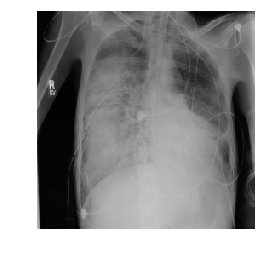

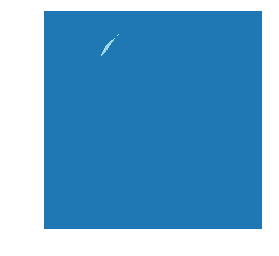

In [0]:
# show PILImage and complimentary PILMask
img = PILImage.create(trn_items[4])
img.show(figsize=(4,4))

msk = PILMask.create(labeller(trn_items[4]))
msk.show(figsize=(4,4), alpha=1)
pass

In [0]:
# check to make sure all pixel values are either 0 (pixel not part of mask) or 1 (pixel is part of mask)
x = np.array(tensor(msk))
unique, counts = np.unique(x, return_counts=True)
dict(zip(unique, counts))

{0.0: 1047327, 1.0: 1249}

## Train DNN

### Create Dataloaders

In [0]:
# pixel labels
codes = np.array(['0', '1']); codes

array(['0', '1'], dtype='<U1')

In [0]:
# initial image size
SIZE = msk.shape; SIZE
INIT_SIZE = 96
BS = 32

In [0]:
def get_dl(sz, bs, path):
    "Return a fastai dataloader from a datablock with image size 'sz', batch size 'bs' and path to image folder 'path'"
    dblck = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=labeller,
                   batch_tfms=[*aug_transforms(size=sz), Normalize.from_stats(*imagenet_stats)])
    return dblck.dataloaders(path, bs=bs)

In [0]:
dls = get_dl(INIT_SIZE, BS, train_png_path)

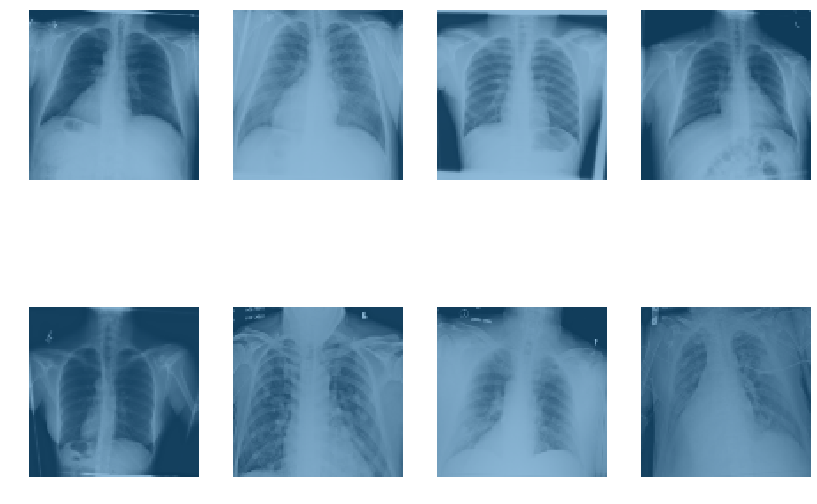

In [0]:
dls.show_batch(max_n=8, vmin=0, vmax=1, figsize=(14,10))

### Configure unet and create Learner

Make a unet_learner that uses some of the new state of the art techniques:

* Self-attention layers: self_attention = True
* Mish activation function: act_cls = Mish
* Ranger optimiser (lookahead optimiser with RAdam (https://dev.fast.ai/optimizer#ranger)
* Custom dice_comp metric (competition metric)

In [0]:
config = unet_config(self_attention=True, act_cls=Mish)
opt = ranger

In [0]:
noise_th = 75.0*(256/128.0)**2                #threshold for the number of predicted pixels
best_thr = 0.2                                #preliminary value of the threshold for metric calculation

# modified fast ai Dice metric to reflect competition metric 

def dice_comp(input, targs, iou=False, eps=1e-8):
    n = targs.shape[0]
    input = torch.softmax(input, dim=1)[:,1,...].view(n,-1)  # use softmax instead of argmax
    input = (input > best_thr).long()
    input[input.sum(-1) < noise_th,...] = 0.0 
    targs = targs.view(n,-1)
    intersect = (input * targs).sum(-1).float()
    union = (input+targs).sum(-1).float()
    if not iou: 
        return ((2.0*intersect + eps) / (union+eps)).mean()
    else: 
        return ((intersect + eps) / (union - intersect + eps)).mean()

In [0]:
# create unet_learner object
learn = unet_learner(dls, resnet34, metrics=[Dice(), dice_comp], config=config, opt_func=opt)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


(0.0007079457864165306, 0.0001258925476577133)

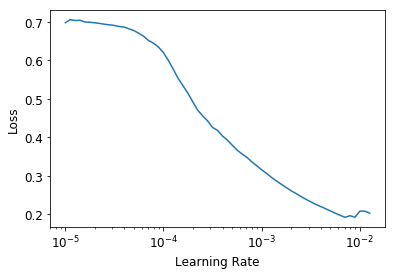

In [0]:
# find optimal learning rate with fastai learning rate finder
learn.lr_find(start_lr=1e-5, end_lr=1e-0)

In [0]:
# # halt here if no GPU enabled
assert torch.cuda.is_available()

### Train using progressive resizing

In [0]:
lr = 1e-3
learn.fit_one_cycle(5, lr)

In [0]:
learn.save('stage_1')

In [0]:
# epochs, image size, batch size, learning rate
RESIZE = [(5, 144, 32, 1e-3), (5, 256, 16, 1e-3)]  # # (epochs, image size, batch size, learning rate)

for params in RESIZE:
    ep, sz, bs, lr = params
    learn.dls = get_dl(sz, bs, train_png_path)
    print(f' Training with image size: {sz}x{sz}')
    learn.fit_one_cycle(ep, lr)

 Training with image size: 144x144


 Training with image size: 256x256


In [0]:
learn.save('stage_2')

In [0]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(lr/50, lr/5, lr/5))

In [0]:
learn.save('model_1')

## Examine predictions on validation set 

In [0]:
# get predictions
inps, preds, targs = learn.get_preds(with_input=True)

# drop the 2nd dimension from preds
preds = preds[:, 1, ...]

# drop singleton dimensions from targs
targs = targs.squeeze()

preds.shape, targs.shape, inps.shape

(torch.Size([2142, 256, 256]),
 torch.Size([2142, 256, 256]),
 torch.Size([2142, 3, 256, 256]))

In [0]:
targs = targs.squeeze()
def dice_overall(preds, targs):
    "Overall dice score of predictions"
    
    # calculate intersection and union of preds and targs areas
    n = preds.shape[0]
    preds = preds.view(n, -1)
    targs = targs.view(n, -1)
    intersect = (preds * targs).sum(-1).float()
    union = (preds+targs).sum(-1).float()
    
    # if union is 0, set values to give dice 1
    u0 = union==0
    intersect[u0], union[u0] = 1, 2
    
    # return dice = intersection/union
    return (2. * intersect / union)

### Best DICE score

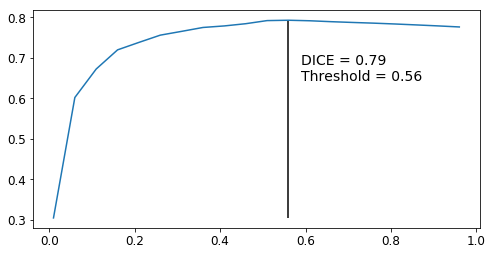

In [0]:
# find optimal threshold for DICE. Similar in principle to ROC Curve.
dices = []
thrs = np.arange(0.01,1,0.05)

for i in progress_bar(thrs):
    preds_m = (preds>i).long()
    dices.append(dice_overall(preds_m,targs).mean())
dices = np.array(dices)

best_thr = thrs[dices.argmax()]
best_dice = dices.max()

# plot dices and select best threshold
plt.figure(figsize=(8,4))
plt.plot(thrs, dices)
plt.vlines(x=best_thr, ymin=dices.min(), ymax=dices.max())
plt.text(best_thr+0.03, best_dice-0.15, f'DICE = {best_dice:.2f} \nThreshold = {best_thr:.2f}', fontsize=14);
plt.show()

### View predictions

tensor([ 208,   41, 1086,  401,  434, 1298, 1667, 1055,  428, 1229, 1394,   46,
         968, 1037,   85,  841, 1225, 1575,  756,  690])


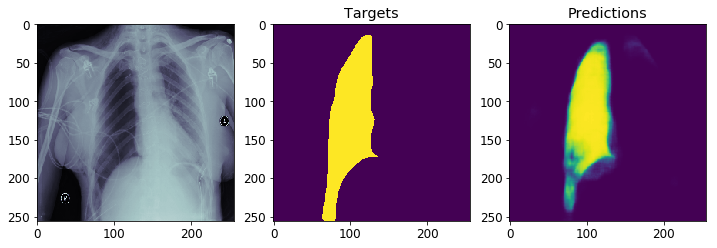

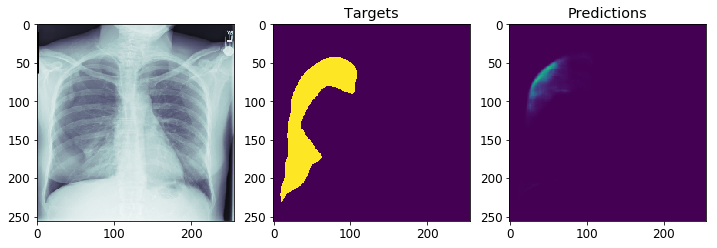

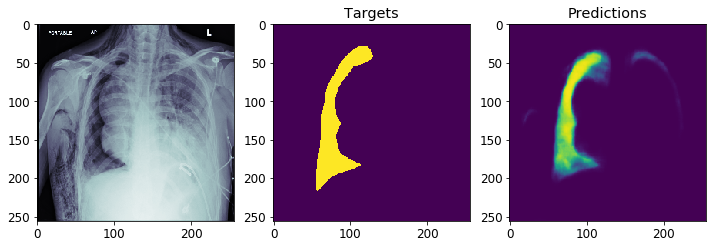

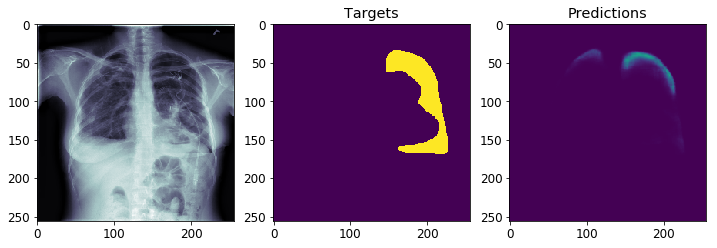

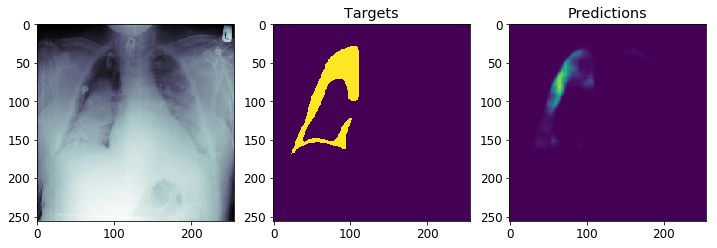

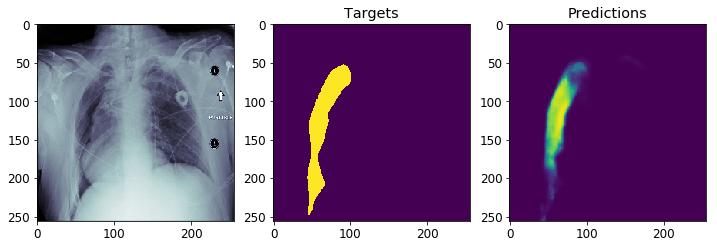

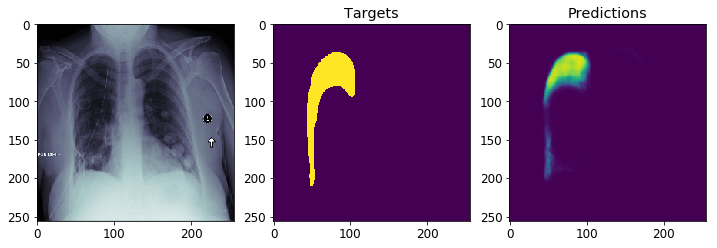

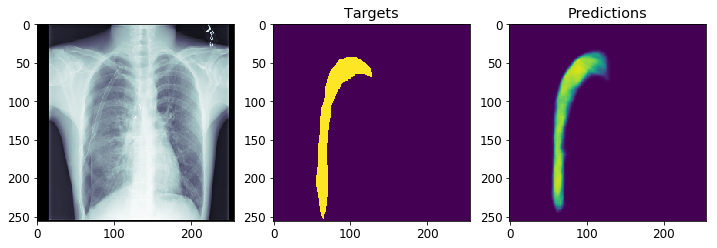

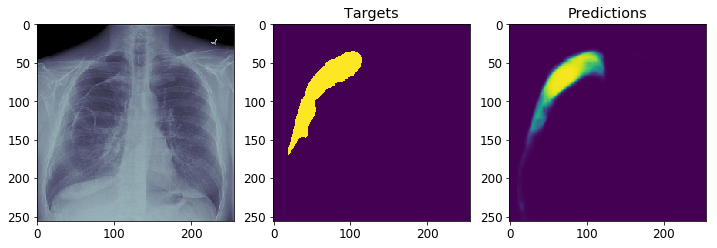

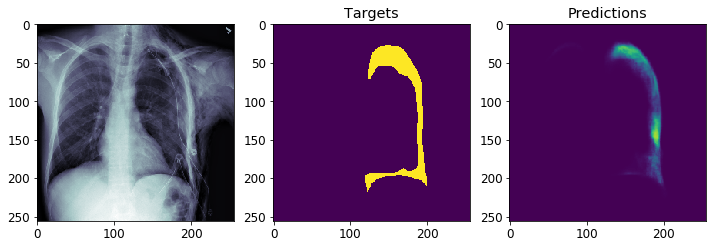

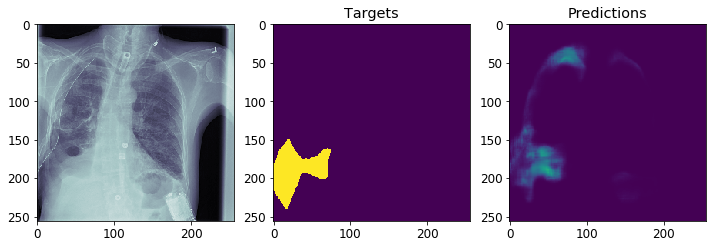

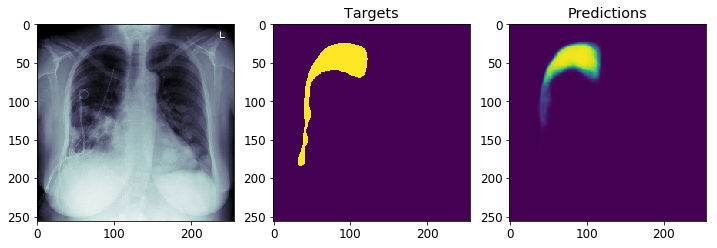

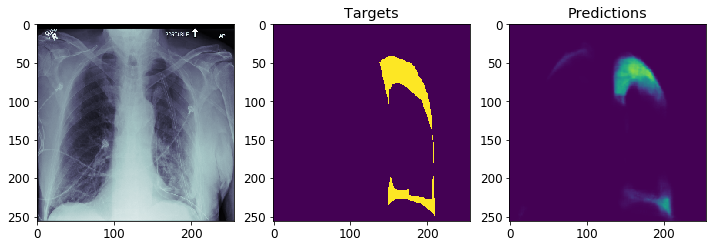

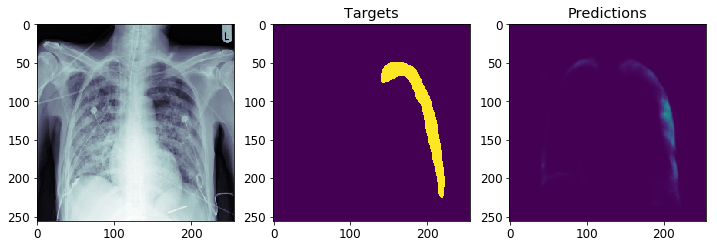

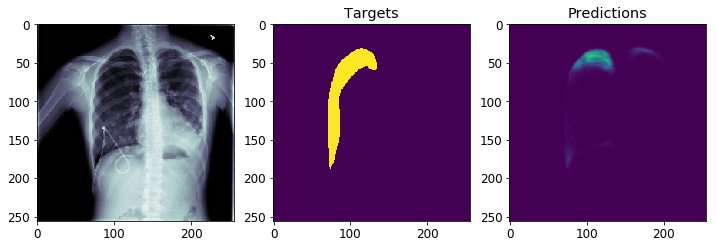

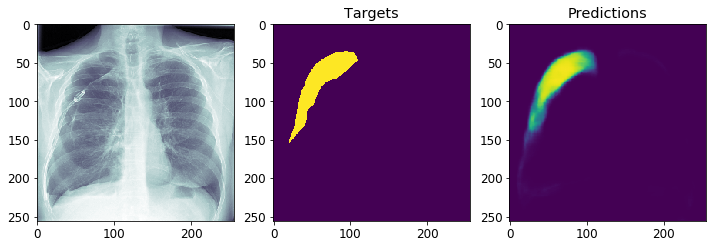

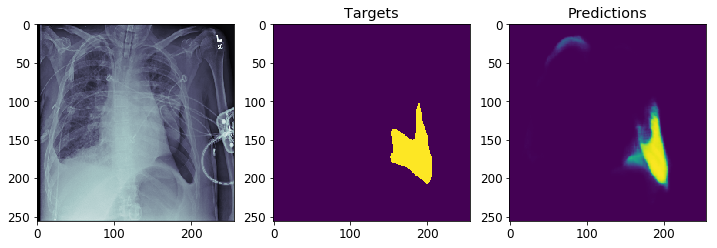

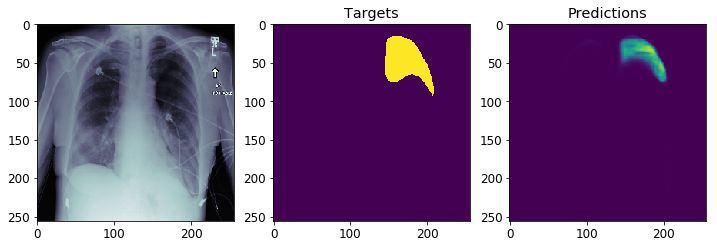

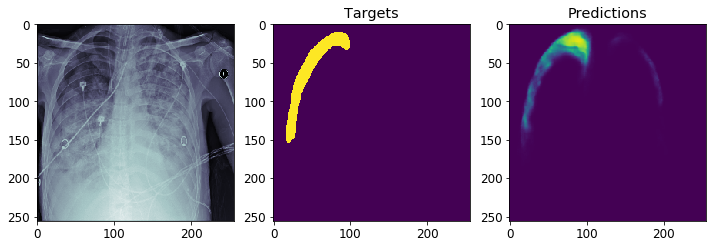

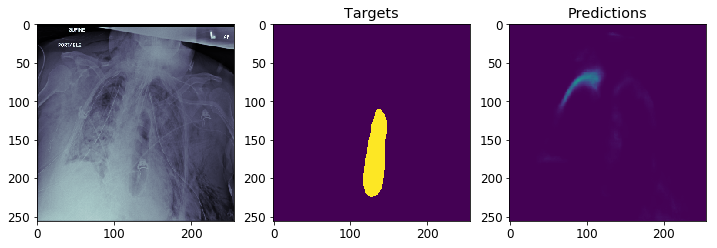

In [0]:
# view a selection of X-rays positive for pneumothorax, masks and predictions from validation set
rows = 20
plot_idx = targs.sum((1,2)).sort(descending=True).indices[:rows]
print(plot_idx)

for idx in plot_idx:
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
    ax0.imshow(inps[idx][0], cmap='bone')
    ax1.imshow(targs[idx], vmin=0, vmax=1)
    ax2.imshow(preds[idx], vmin=0, vmax=1)
    ax1.set_title('Targets')
    ax2.set_title('Predictions')

In [0]:
preds[1].max()


tensor(0.0043)

## Inference

Let's make some predictions on unseen (and unlabelled) data - we'll use the Kaggle test set.

In [0]:
# create png files for first 100 test images and save to disk
test_png_path = 'test_png/'
test_list = glob2.glob(os.path.join(KAGGLE_TEST_PATH, '**/*.dcm'))
    
if not os.path.exists(test_png_path):
    os.makedirs(test_png_path)

res = Parallel(n_jobs=8, backend='threading')(delayed(convert_images)(i, test_png_path) for i in tqdm(test_list[:100], total=len(test_list[:100])))

In [0]:
# get paths to png files 
test_items = get_files(test_png_path, extensions=[".png"], recurse=True, folders=None)

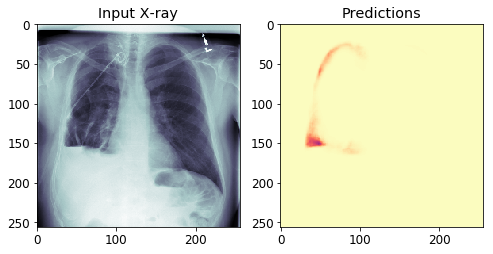

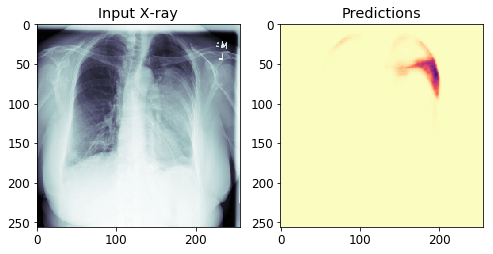

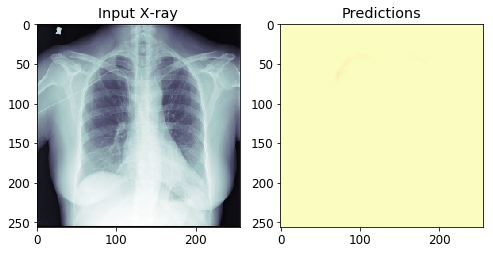

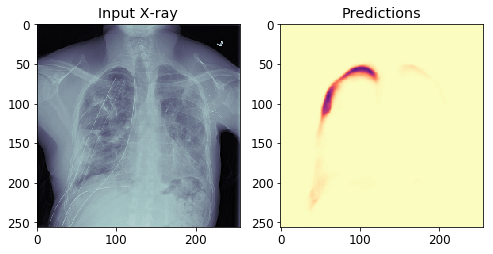

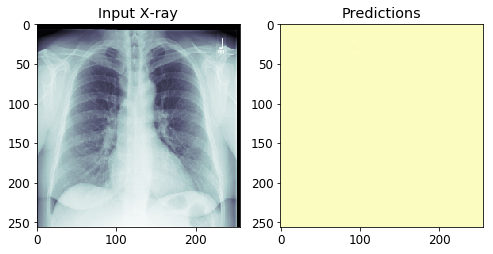

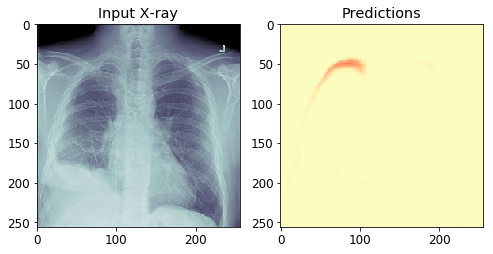

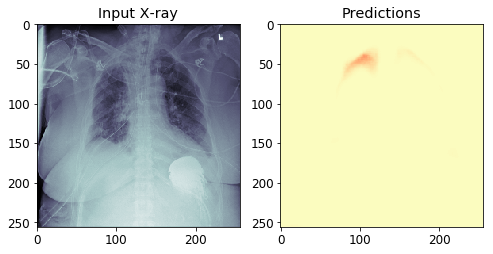

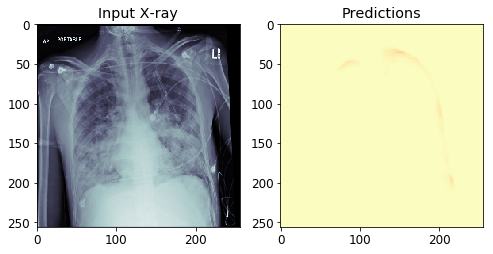

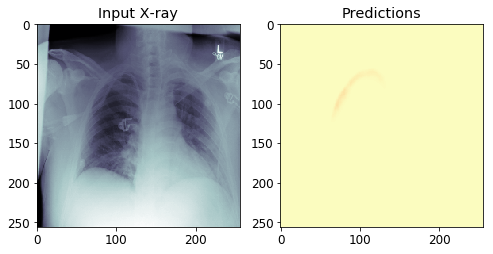

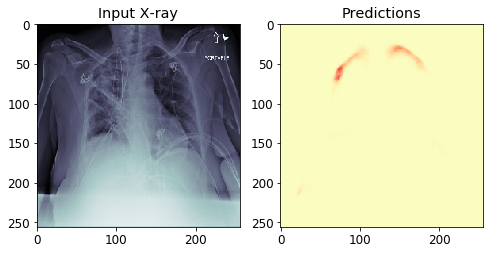

In [0]:
# print selection of X-rays and predictions from unlableed test set.
for i in test_items[:10]:
    _, _, out = learn.predict(i)

    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 4))
    ax0.imshow(imread(i), cmap='bone')
    ax1.imshow(out[0], vmin=0, vmax=1, cmap='magma')
    ax0.set_title('Input X-ray')
    ax1.set_title('Predictions')

## References

Relevant references

* SIIM Pneumothorax challenge. https://siim.org/page/pneumothorax_challenge
* Pneumothorax symptoms and causes. Mayo Clnic.https://www.mayoclinic.org/diseases-conditions/pneumothorax/symptoms-causes/syc-20350367
* Olaf Ronneberger et al. U-Net: Convolutional Networks for Biomedical Image Segmentation. (2015). https://arxiv.org/abs/1505.04597
* Jeremy Zhang. Unet line by line explanation. (2018). https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5
